In [19]:
import networkx as nx
from queue import PriorityQueue

In [20]:
def build_weighted_graph():
    graph = nx.Graph()
    edge_list = [(0,1, {"weight":1}),
                 (0,6, {"weight": 4}),
                 (1,2, {"weight":3}),
                 (0,2, {"weight":1}),
                 (2,3, {"weight":1}),
                 (1,3, {"weight":3}),
                 (0,4, {"weight":1}),
                 (3,4, {"weight":1}),
                 (2,4, {"weight":1}),
                 (4,5, {"weight":2}),
                 (5,6, {"weight":1}),
                 (4,6, {"weight":3})]
    graph.add_edges_from(edge_list)
    return graph

In [21]:
def plot_graph(graph : nx.Graph):
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, with_labels=True, pos=pos)
    edge_labels = dict([((n1, n2), f'{graph[n1][n2]["weight"]}')
                        for n1, n2 in graph.edges])
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

In [22]:
def dijkstra_modified(graph : nx.Graph, start : int):
    """Runs Dijkstra's algorithm on the given input graph and compute sigmas for betweennes centrality computation on the fly.

    Args:
        graph (nx.Graph): Input network.
        start (int): ID of start node.

    Returns:
        dict: Keys are nodes IDs for given node t and values are sigma_st.
        dict: Dictionary storing for each node the predecessor node in a shortest path.
    """
    num_nodes = graph.number_of_nodes()
    
    # Data structure initialization.
    settled = set()
    tentatives = {start : 0}
    predecessors = {start : -1}
    
    # Data structure for storing number of shortest paths.
    sigmas = [0]*num_nodes
    sigmas[start] = 1
    
    prio_queue = PriorityQueue()
    prio_queue.put((0, start))
    
    
    # Start iterating start node.
    while len(settled)!=num_nodes:
        # Take next node in prio queue.
        next = prio_queue.get()
        
        # Check if already settled.
        if next[1] in settled:
            continue
        
        # Else, traverse neighbors and update their tentative distances.
        for nbor in graph.neighbors(next[1]):
            current_path_distance = tentatives[next[1]]+(graph[next[1]][nbor])['weight']
            if nbor in tentatives and current_path_distance == tentatives[nbor]:
                # This means that also shortest path over current node exists.
                sigmas[nbor] = sigmas[nbor] + sigmas[next[1]]

            if not nbor in tentatives or current_path_distance < tentatives[nbor]:
                # Update tentative distance of neighbor.
                tentatives[nbor] = current_path_distance
                prio_queue.put((current_path_distance, nbor))
                predecessors[nbor] = next[1]
                # Update number of shortest path to nbor.
                sigmas[nbor] = sigmas[next[1]]
        
        # Current node is now settled.
        settled.add(next[1])
    
    # Postprocess sigma entries.
    sigmas_dict = {(start, i) : sigmas[i] for i in range(len(sigmas))}
    distances = {(start, key) : val for (key, val) in tentatives.items()}
    
    return distances, predecessors, sigmas_dict
    

In [23]:
def betweenness(graph : nx.Graph, node):
    """Compute betweenness centrality of given node in given network.

    Args:
        graph (nx.Graph): Input network.
        start (int): ID of node to compute centrality for.

    Returns:
        float: Betweenness centrality of node.
    """

    sigmas_dict = dict()
    distances_dict = dict()
    
    # Compute sigmas for each possible starting node.
    for start in graph.nodes():
        distances, _, sigmas = dijkstra_modified(graph, start)
        sigmas_dict.update(sigmas)
        distances_dict.update(distances)

    all_nodes = list(graph.nodes())
    all_nodes.remove(node)
    
    centrality = 0.0
    # Consider all combinations of start and end nodes exluding the analyzed node.
    for start in all_nodes:
        for end in all_nodes:
            if start != end:
                # Compute sigma_st(u) for given start-end combination.
                if distances_dict[(start, end)] < distances_dict[(start, node)] + distances_dict[(node, end)]:
                    sigma_st_u = 0.0
                else:
                    sigma_st_u = sigmas_dict[(start, node)] * sigmas_dict[(node, end)]
                centrality = centrality + (sigma_st_u / sigmas_dict[(start, end)])
    

    return centrality
        

Distances: {(0, 0): 0, (0, 1): 1, (0, 6): 4, (0, 2): 1, (0, 4): 1, (0, 3): 2, (0, 5): 3}
Predecessors: {0: -1, 1: 0, 6: 0, 2: 0, 4: 0, 3: 2, 5: 4}
Sigmas: {(0, 0): 1, (0, 1): 1, (0, 2): 1, (0, 3): 2, (0, 4): 1, (0, 5): 1, (0, 6): 3}


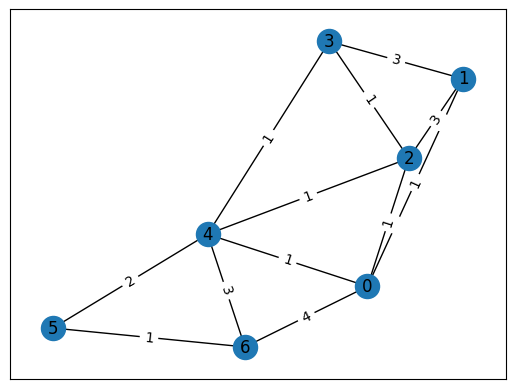

In [24]:
graph = build_weighted_graph()
plot_graph(graph)

distances, predecessors, sigmas = dijkstra_modified(graph, 0)
print("Distances:", distances)
print("Predecessors:", predecessors)
print("Sigmas:", sigmas)

# node = 4
# centrality = betweenness(graph, node)

# Sort nodes by computed betweenness centrality.
centralities = [(node, betweenness(graph, node)) for node in list(graph.nodes())]
sorted_nodes = sorted(centralities, key=lambda x: x[1], reverse=True)
#print(centralities)
#print(sorted_nodes)
